In [67]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [1]:
# create list of strings, each string representing one article
# there are a variable number of articles per file
corpus = []
for txt in sorted(Path('Articles').iterdir()):
    with open(txt) as f:
        # split article on \f (feed file character)
        documents = "\n".join(f.readlines()).split("\f")
        corpus.extend(documents)

# there are 1622 articles in the corpus
len(corpus)

1622

In [2]:
# skip metadata at beginning and end of every document
def remove_metadata(document: str) -> str:
    lines = [line for l in document.split("\n") if (line := l.strip())]
    for i, line in enumerate(lines):
        lower_line = line.lower()
        # slice article after copyright (usually lines 10-11)
        if lower_line.startswith("copyright") or lower_line.startswith("©"):
            # slice article before the document ID (last line)
            return "\n".join(lines[i + 1: -1])

In [15]:

TOKENIZER = RegexpTokenizer(r"\w+")  # splits on any non-word character
LEMMATIZER = WordNetLemmatizer()
# STEMMER = SnowballStemmer('english')

# removing the lemmas "say" and "mr" because a lot of these articles are from the NYT and they use those a lot
STOPWORDS = set(stopwords.words('english')) | {"say", "mr"}

def preprocess_text(text: str) -> str:
    
    # remove metadata using above function
    meta_stripped = remove_metadata(text)
    
    # tokenize, remove punctuation
    tokens: list[str] = TOKENIZER.tokenize(meta_stripped)

    # lowercase all, lemmatize verbs
    lemmas = [LEMMATIZER.lemmatize(token.lower(), pos="v") for token in tokens]
    
    # # stem tokens
    # stems = [STEMMER.stem(l) for l in lemmas]

    # remove stopwords, numbers, and non-english words
    keywords = [w for w in lemmas if all((w not in STOPWORDS, w.isascii(), w.isalpha()))]
    
    return " ".join(keywords)

In [16]:
# create list of preprocessed strings, each string is an article (document)
processed_corpus = [preprocess_text(document) for document in corpus]

In [73]:
# extract features using TF-IDF and store in pandas dataframe
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_corpus).toarray()
tokens = vectorizer.get_feature_names_out()
df = pd.DataFrame(data=X, columns=tokens)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Columns: 32752 entries, aa to zyed
dtypes: float64(32752)
memory usage: 405.3 MB


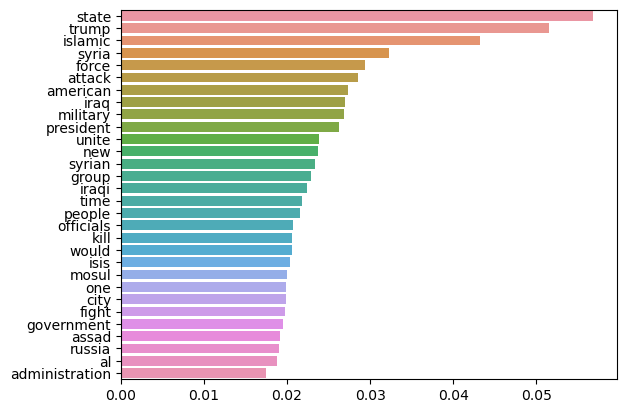

In [90]:
top_30 = df.mean().sort_values(ascending=False)[:30]
sns.barplot(y=top_30.index, x=top_30)
plt.show()

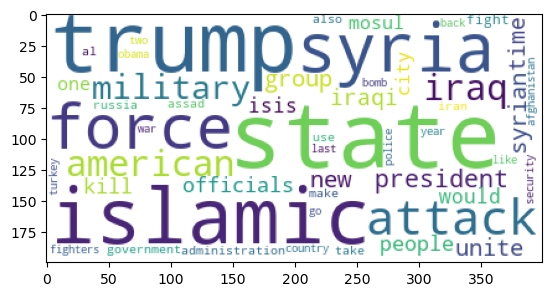

In [88]:
wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.imshow(wordcloud)
plt.show()